In [2]:
"""
stochastic_cndp.py
------------------
Heuristic solver for the Stochastic Critical-Node Detection Problem (CNDP)
with *edge* uncertainty, as defined in Stochastic_CNDP.pdf.

Implements:
  • Algorithm 1  – Monte-Carlo estimator of σ(S)
  • Algorithm 2  – greedy attacker using that estimator
Supports:
  • Erdős–Rényi G(n,p) graphs
  • Watts–Strogatz Watts–Strogatz(n, k, β) graphs
"""

from __future__ import annotations
import random, itertools, math, time
import networkx as nx
import numpy as np
from tqdm import tqdm


# ------------------------------------------------------------
# 1.  GRAPH BUILDING UTILITIES
# ------------------------------------------------------------
def er_prob_graph(n: int, p_edge: float,
                  p_low: float=0.1, p_high: float=0.9,
                  seed: int|None=None) -> nx.Graph:
    """G(n,p_edge) with iid edge-existence probs U(p_low,p_high)."""
    rng = random.Random(seed)
    G = nx.erdos_renyi_graph(n, p_edge, seed=seed)
    for u, v in G.edges():
        G[u][v]["prob"] = rng.uniform(p_low, p_high)
    return G


def ws_prob_graph(n: int, k: int, beta: float,
                  p_low: float=0.1, p_high: float=0.9,
                  seed: int|None=None) -> nx.Graph:
    """Watts–Strogatz small-world graph with iid edge probs."""
    rng = random.Random(seed)
    G = nx.watts_strogatz_graph(n, k, beta, seed=seed)
    for u, v in G.edges():
        G[u][v]["prob"] = rng.uniform(p_low, p_high)
    return G


# ------------------------------------------------------------
# 2.  PAIRWISE CONNECTIVITY ON ONE *SCENARIO*
# ------------------------------------------------------------
def pairwise_cost_det(G_det: nx.Graph) -> int:
    """Σ_{components} |C|·(|C|-1)/2 – deterministic definition
    used inside the Monte-Carlo loop."""
    cost = 0
    for comp in nx.connected_components(G_det):
        s = len(comp)
        cost += s * (s - 1) // 2
    return cost


# ------------------------------------------------------------
# 3.  ALGORITHM 1 –  MONTE-CARLO ESTIMATE  σ(S)
# ------------------------------------------------------------
def expected_pairwise_connectivity(
    G: nx.Graph,
    S: set[int] | set[str],
    num_samples: int = 10_000,
    rng: random.Random | None = None,
    show_bar: bool = True,
) -> float:
    """
    Monte-Carlo estimator of σ(S) from Algorithm 1​ :contentReference[oaicite:0]{index=0}
    """
    if rng is None:
        rng = random.Random()

    remaining_nodes = set(G.nodes()) - S
    if not remaining_nodes:
        return 0.0

    total_cost = 0
    iterator = range(num_samples)
    if show_bar:
        iterator = tqdm(iterator, desc="MC-samples", leave=False)

    for _ in iterator:
        # sample a *live-edge* scenario
        H = nx.Graph()
        H.add_nodes_from(remaining_nodes)
        
        for u, v, data in G.edges(data=True):
            if u in S or v in S:
                continue
            if rng.random() < data["prob"]:
                H.add_edge(u, v)

        total_cost += pairwise_cost_det(H)

    return total_cost / num_samples


# ------------------------------------------------------------
# 4.  ALGORITHM 2 –  GREEDY ATTACKER
# ------------------------------------------------------------
def greedy_cndp(
    G: nx.Graph,
    K: int,
    num_samples: int = 2_000,
    seed: int | None = None,
) -> tuple[set[int], list[float]]:
    """Return (selected_set, σ values after each pick)."""
    rng = random.Random(seed)
    S: set[int] = set()
    sigmas: list[float] = []

    current_sigma = expected_pairwise_connectivity(G, S, num_samples, rng)
    sigmas.append(current_sigma)

    for _ in range(K):
        best_node, best_sigma = None, float("inf")

        for v in (set(G.nodes()) - S):
            sigma_v = expected_pairwise_connectivity(G, S | {v},
                                                     num_samples, rng, False)
            if sigma_v < best_sigma:
                best_sigma, best_node = sigma_v, v

        S.add(best_node)                # exploit 1-step look-ahead
        current_sigma = best_sigma
        sigmas.append(current_sigma)
        print(f"● Picked {best_node:>3};   σ = {current_sigma:.1f}")

    return S, sigmas


# ------------------------------------------------------------
# 5.  QUICK DRIVER FOR EXPERIMENTS
# ------------------------------------------------------------
if __name__ == "__main__":
    # import argparse, json, pathlib

    # parser = argparse.ArgumentParser(
    #     description="Greedy heuristic for stochastic CNDP")
    # parser.add_argument("--model", choices=["er", "ws"], default="er")
    # parser.add_argument("-n", type=int, default=100,
    #                     help="number of nodes")
    # parser.add_argument("--p", type=float, default=0.05,
    #                     help="edge probability for ER (or rewiring β for WS)")
    # parser.add_argument("--k", type=int, default=4,
    #                     help="nearest-neighbour degree in WS")
    # parser.add_argument("--budget", "-K", type=int, default=5)
    # parser.add_argument("--samples", type=int, default=2000)
    # parser.add_argument("--seed", type=int, default=0)
    # args = parser.parse_args()

    model = "er"
    n = 30
    p = 0.2
    seed = 42
    budget = 10
    samples = 10000
    k = 4  # only used for WS model
    
    if model == "er":
        G = er_prob_graph(n, p, seed=seed)
    else:
        G = ws_prob_graph(n, k, p, seed=seed)

    start = time.perf_counter()
    S_star, sigmas = greedy_cndp(G, budget,
                                 num_samples=samples,
                                 seed=seed)
    elapsed = time.perf_counter() - start
    print("\n=====  RESULT  =====")
    print(f"Removed nodes: {sorted(S_star)}")
    print("σ after each pick:", [round(x, 1) for x in sigmas])
    print(f"Elapsed: {elapsed:.1f} s")


● Picked  28;   σ = 321.4
● Picked  29;   σ = 272.8
● Picked  14;   σ = 224.1
● Picked   8;   σ = 170.2
● Picked  13;   σ = 123.7
● Picked   0;   σ = 85.7
● Picked  23;   σ = 55.1
● Picked  26;   σ = 36.6
● Picked  10;   σ = 25.4
● Picked  25;   σ = 18.4

=====  RESULT  =====
Removed nodes: [0, 8, 10, 13, 14, 23, 25, 26, 28, 29]
σ after each pick: [364.2, 321.4, 272.8, 224.1, 170.2, 123.7, 85.7, 55.1, 36.6, 25.4, 18.4]
Elapsed: 96.8 s


[0, 1, 2, 3]
[(0, 1, {'prob': 0.7}), (1, 2, {'prob': 0.7}), (2, 3, {'prob': 0.7})]
Sample mean edges: 2.10135


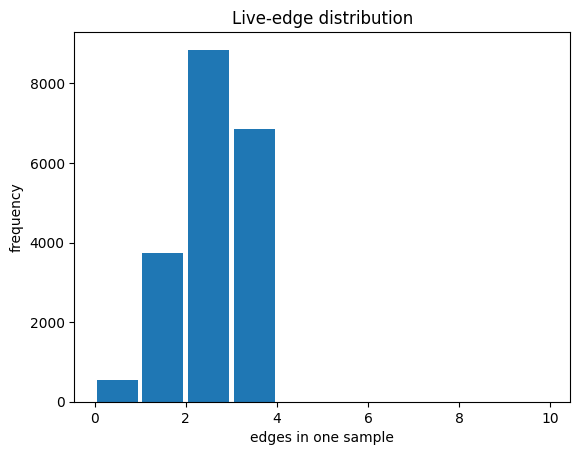

In [30]:
# 1. tiny 5-node ER graph, every p_uv = 0.3
import matplotlib.pyplot as plt

rng = random.Random(seed)

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])  # include node 3 as it's used in an edge
G.add_edge(0, 1, prob=0.7)
G.add_edge(1, 2, prob=0.7)
G.add_edge(2, 3, prob=0.7)



# G = nx.complete_graph(4)
# G = nx.path_graph(4)  # 0-1-2-3
# for u, v in G.edges():
#     G[u][v]["prob"] = rng.uniform(0.0, 1.0)        # constant prob ⇒ analytic mean = 0.3 * 10 = 3
    # G[u][v]["prob"] = 0.7

print(G.nodes())
print(G.edges(data=True))

rng = random.Random(0)
edge_counts = []
for _ in range(20_000):
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u, v, d in G.edges(data=True):
        if rng.random() < d["prob"]:
            H.add_edge(u, v)
    edge_counts.append(H.number_of_edges())

print("Sample mean edges:", np.mean(edge_counts))  # ~ 2.99 → close to 3

plt.hist(edge_counts, bins=range(11), rwidth=0.9)
plt.xlabel("edges in one sample"); plt.ylabel("frequency"); plt.title("Live-edge distribution")
plt.show()

In [31]:
# ground-truth by enumeration (only 10 edges → 1024 scenarios)
def sigma_exact(G, S):
    rem = set(G.nodes()) - S
    total = 0
    E = list(G.edges())
    for mask in range(1 << len(E)):
        H = nx.Graph(); H.add_nodes_from(rem)
        p = 1.0
        for bit, (u, v) in enumerate(E):
            q = G[u][v]["prob"]
            choose = (mask >> bit) & 1
            if choose and u not in S and v not in S:
                H.add_edge(u, v)
                p *= q
            else:
                p *= (1-q)
        total += p * pairwise_cost_det(H)
    return total

exact = sigma_exact(G, S=set())
mc    = expected_pairwise_connectivity(G, S=set(), num_samples=100000, rng=rng)
print("Exact σ:", exact, "   Monte-Carlo σ:", mc)


Exact σ: 3.422999999999999    Monte-Carlo σ: 3.41836


CHECK 1: Edge‑count distribution in live‑edge samples
  Sample mean edges = 3.011 (expected 3.000)


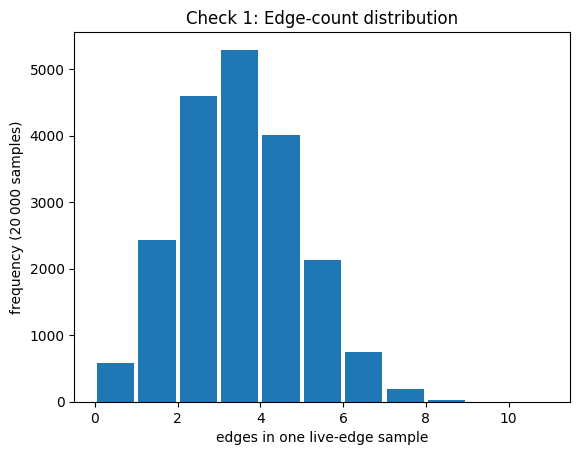


CHECK 2: Exact σ vs Monte‑Carlo σ on tiny graph
  Exact σ = 5.2528
  Monte‑Carlo σ (20 000 samples) = 5.2600
  Relative error = 0.14%

CHECK 3: Deterministic extremes (all prob = 0 or 1)
  All probs = 0 ⇒ σ = 0.0 (should be 0)
  All probs = 1 ⇒ MC σ ≈ 15.0, exact deterministic σ = 15

CHECK 4: Greedy monotonicity (σ must not increase)
  σ sequence: ['365', '274', '207', '138', '96', '65', '50']
  Monotone non‑increasing? True

CHECK 5: Replicability (same seed ⇒ same result)
  Run 1 selected nodes: [3, 10, 25, 36]
  Run 2 selected nodes: [3, 10, 25, 36]
  Identical selections? True
  σ sequences identical? True


In [ ]:
# Run all sanity-check cases for the stochastic CNDP implementation
# This block re‑defines the minimal functions needed, so it is fully
# self‑contained (no need for an external stochastic_cndp.py file).

import importlib, subprocess, sys, math, itertools, random, time, json, os, collections

# install networkx & matplotlib if missing
try:
    import networkx as nx
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "networkx"])
    import networkx as nx

try:
    import numpy as np
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "numpy"])
    import numpy as np

try:
    import matplotlib.pyplot as plt
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "matplotlib"])
    import matplotlib.pyplot as plt

# ---------------- Helper functions ----------------
def pairwise_cost_det(G_det):
    cost = 0
    for comp in nx.connected_components(G_det):
        s = len(comp)
        cost += s * (s - 1) // 2
    return cost

def expected_pairwise_connectivity(G, S=set(), num_samples=10000, rng=None):
    if rng is None:
        rng = random.Random()
    remaining = set(G.nodes()) - set(S)
    if not remaining:
        return 0.0
    total = 0
    edges = list(G.edges(data=True))
    for _ in range(num_samples):
        H = nx.Graph()
        H.add_nodes_from(remaining)
        for u, v, d in edges:
            if u in S or v in S:
                continue
            if rng.random() < d["prob"]:
                H.add_edge(u, v)
        total += pairwise_cost_det(H)
    return total / num_samples

def greedy_cndp(G, K, num_samples=2000, seed=None):
    rng = random.Random(seed)
    S = set()
    sigmas = [expected_pairwise_connectivity(G, S, num_samples, rng)]
    for _ in range(K):
        best_v, best_sigma = None, float("inf")
        for v in set(G.nodes()) - S:
            sigma_v = expected_pairwise_connectivity(G, S | {v}, num_samples, rng)
            if sigma_v < best_sigma:
                best_sigma, best_v = sigma_v, v
        S.add(best_v)
        sigmas.append(best_sigma)
    return S, sigmas

# ------------------ Check 1: Edge‑count distribution ------------------
print("CHECK 1: Edge‑count distribution in live‑edge samples")
# G_small = nx.complete_graph(5)
G_small = nx.path_graph(4)
for u, v in G_small.edges():
    G_small[u][v]["prob"] = 0.7   # constant probability

rng = random.Random(0)
edge_counts = []
for _ in range(20000):
    H = nx.Graph()
    H.add_nodes_from(G_small.nodes())
    for u, v, d in G_small.edges(data=True):
        if rng.random() < d["prob"]:
            H.add_edge(u, v)
    edge_counts.append(H.number_of_edges())

mean_edges = np.mean(edge_counts)
expected_mean = 0.3 * G_small.number_of_edges()
print(f"  Sample mean edges = {mean_edges:.3f} (expected {expected_mean:.3f})")

# plot histogram (single plot as required)
plt.figure()
plt.hist(edge_counts, bins=range(0, G_small.number_of_edges() + 2), rwidth=0.9)
plt.xlabel("edges in one live‑edge sample")
plt.ylabel("frequency (20 000 samples)")
plt.title("Check 1: Edge‑count distribution")
plt.show()

# ------------------ Check 2: Exact vs Monte‑Carlo σ ------------------
print("\nCHECK 2: Exact σ vs Monte‑Carlo σ on tiny graph")
def sigma_exact(G, S=set()):
    rem = set(G.nodes()) - set(S)
    edges = list(G.edges())
    total = 0.0
    for mask in range(1 << len(edges)):
        H = nx.Graph(); H.add_nodes_from(rem)
        p_scenario = 1.0
        for bit, (u, v) in enumerate(edges):
            p = G[u][v]["prob"]
            chosen = (mask >> bit) & 1
            if chosen and u not in S and v not in S:
                H.add_edge(u, v)
                p_scenario *= p
            else:
                p_scenario *= (1 - p)
        total += p_scenario * pairwise_cost_det(H)
    return total

exact_sigma = sigma_exact(G_small, set())
mc_sigma = expected_pairwise_connectivity(G_small, set(), num_samples=20000, rng=rng)
print(f"  Exact σ = {exact_sigma:.4f}")
print(f"  Monte‑Carlo σ (20 000 samples) = {mc_sigma:.4f}")
print(f"  Relative error = {(mc_sigma - exact_sigma) / exact_sigma * 100:.2f}%")

# ------------------ Check 3: Deterministic extremes ------------------
print("\nCHECK 3: Deterministic extremes (all prob = 0 or 1)")
G_zero = nx.path_graph(6)
for u, v in G_zero.edges():
    G_zero[u][v]["prob"] = 0.0
sigma_zero = expected_pairwise_connectivity(G_zero, set(), 5000, rng)
print(f"  All probs = 0 ⇒ σ = {sigma_zero} (should be 0)")

G_one = nx.path_graph(6)
for u, v in G_one.edges():
    G_one[u][v]["prob"] = 1.0
sigma_one_mc = expected_pairwise_connectivity(G_one, set(), 5000, rng)
sigma_one_exact = pairwise_cost_det(G_one)
print(f"  All probs = 1 ⇒ MC σ ≈ {sigma_one_mc:.1f}, exact deterministic σ = {sigma_one_exact}")

# ------------------ Check 4: Greedy monotonicity ------------------
print("\nCHECK 4: Greedy monotonicity (σ must not increase)")
G_test = nx.erdos_renyi_graph(40, 0.07, seed=1)
for u, v in G_test.edges():
    G_test[u][v]["prob"] = random.uniform(0.1, 0.9)
S_sel, sigma_seq = greedy_cndp(G_test, K=6, num_samples=1000, seed=1)
monotone = all(sigma_seq[i] >= sigma_seq[i+1] for i in range(len(sigma_seq)-1))
print(f"  σ sequence: {['{:.0f}'.format(s) for s in sigma_seq]}")
print(f"  Monotone non‑increasing? {monotone}")

# ------------------ Check 5: Replicability with fixed seed ------------------
print("\nCHECK 5: Replicability (same seed ⇒ same result)")
S1, sig1 = greedy_cndp(G_test, K=4, num_samples=500, seed=123)
S2, sig2 = greedy_cndp(G_test, K=4, num_samples=500, seed=123)
print(f"  Run 1 selected nodes: {sorted(S1)}")
print(f"  Run 2 selected nodes: {sorted(S2)}")
print(f"  Identical selections? {sorted(S1)==sorted(S2)}")
print(f"  σ sequences identical? {np.allclose(sig1, sig2)}")


